# Predictive Modelling for Predictive Maintenance
We will now be building models using machine and deep learning, test their performance and evaluate them.


## Outline

- [Label Construction](#Label-Construction)
- [Modeling with XGBoost](#Modeling)
  - [Training, Validation and Testing](#Training,-Validation-and-Testing)
  - [Evaluation](#Evaluation)
- [Modeling with Random Forest Network](#Modeling)
  - [Training, Validation and Testing](#Training,-Validation-and-Testing)
  - [Evaluation](#Evaluation)
- [Summary](#Summary)

## 1. Label Construction / Fault Signature Generation

In [1]:
import pandas as pd, numpy as np

final_feat=pd.read_pickle('final_feat.pkl')
final_feat.head(10)

,machineID,datetime,voltmean_2h,rotatemean_2h,pressuremean_2h,vibrationmean_2h,voltstd_2h,rotatestd_2h,pressurestd_2h,vibrationstd_2h,...,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age
0,1,2015-01-01 18:00:00,163.662467,415.283899,100.130819,40.609740,4.806224,46.386709,5.161658,2.921849,...,0.0,0.0,0.0,0.0,19.500000,214.500000,154.500000,169.500000,model3,18
1,1,2015-01-01 19:00:00,156.808723,469.378588,91.246708,41.326118,4.886435,30.114734,7.402372,3.934960,...,0.0,0.0,0.0,0.0,19.541667,214.541667,154.541667,169.541667,model3,18
2,1,2015-01-01 20:00:00,168.046302,454.436086,89.748697,42.737872,20.778772,51.246623,5.283865,1.938438,...,0.0,0.0,0.0,0.0,19.583333,214.583333,154.583333,169.583333,model3,18
3,1,2015-01-01 21:00:00,176.537275,410.330219,93.360371,40.553536,8.770723,11.128493,0.176188,1.150680,...,0.0,0.0,0.0,0.0,19.625000,214.625000,154.625000,169.625000,model3,18
4,1,2015-01-01 22:00:00,176.401274,452.190080,89.499201,45.380684,8.578387,70.327275,5.284331,7.977298,...,0.0,0.0,0.0,0.0,19.666667,214.666667,154.666667,169.666667,model3,18
5,1,2015-01-01 23:00:00,166.901396,473.420815,90.004993,46.570569,22.013243,40.302482,5.999629,6.294547,...,0.0,0.0,0.0,0.0,19.708333,214.708333,154.708333,169.708333,model3,18
6,1,2015-01-02 00:00:00,161.935539,478.404510,92.788400,37.184242,14.990462,47.350492,2.063297,6.979724,...,0.0,0.0,0.0,0.0,19.750000,214.750000,154.750000,169.750000,model3,18
7,1,2015-01-02 01:00:00,176.316445,499.299334,94.031672,35.572804,5.347211,17.800749,3.821549,4.700806,...,0.0,0.0,0.0,0.0,19.791667,214.791667,154.791667,169.791667,model3,18
8,1,2015-01-02 02:00:00,174.851674,503.082558,87.807347,39.526825,7.418710,23.151035,12.624073,0.891025,...,0.0,0.0,0.0,0.0,19.833333,214.833333,154.833333,169.833333,model3,18
9,1,2015-01-02 03:00:00,168.367486,473.251790,85.290339,42.399613,1.751317,65.338112,9.064486,3.171711,...,0.0,0.0,0.0,0.0,19.875000,214.875000,154.875000,169.875000,model3,18


In [2]:
failures = pd.read_csv('PdM_failures.csv')
failures['datetime'] = pd.to_datetime(failures['datetime'])
failures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   datetime   761 non-null    datetime64[ns]
 1   machineID  761 non-null    int64         
 2   failure    761 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 18.0+ KB


In [3]:
labeled_features = final_feat.merge(failures, on=['datetime', 'machineID'], how='left')
labeled_features = labeled_features.fillna(method='bfill', axis=1,limit=7) # fill backward up to 24h
labeled_features = labeled_features.fillna('none')
labeled_features.head(8)

,machineID,datetime,voltmean_2h,rotatemean_2h,pressuremean_2h,vibrationmean_2h,voltstd_2h,rotatestd_2h,pressurestd_2h,vibrationstd_2h,...,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
0,1,2015-01-01 18:00:00,163.662467,415.283899,100.130819,40.609740,4.806224,46.386709,5.161658,2.921849,...,0.0,0.0,0.0,19.500000,214.500000,154.500000,169.500000,model3,18,none
1,1,2015-01-01 19:00:00,156.808723,469.378588,91.246708,41.326118,4.886435,30.114734,7.402372,3.934960,...,0.0,0.0,0.0,19.541667,214.541667,154.541667,169.541667,model3,18,none
2,1,2015-01-01 20:00:00,168.046302,454.436086,89.748697,42.737872,20.778772,51.246623,5.283865,1.938438,...,0.0,0.0,0.0,19.583333,214.583333,154.583333,169.583333,model3,18,none
3,1,2015-01-01 21:00:00,176.537275,410.330219,93.360371,40.553536,8.770723,11.128493,0.176188,1.150680,...,0.0,0.0,0.0,19.625000,214.625000,154.625000,169.625000,model3,18,none
4,1,2015-01-01 22:00:00,176.401274,452.190080,89.499201,45.380684,8.578387,70.327275,5.284331,7.977298,...,0.0,0.0,0.0,19.666667,214.666667,154.666667,169.666667,model3,18,none
5,1,2015-01-01 23:00:00,166.901396,473.420815,90.004993,46.570569,22.013243,40.302482,5.999629,6.294547,...,0.0,0.0,0.0,19.708333,214.708333,154.708333,169.708333,model3,18,none
6,1,2015-01-02 00:00:00,161.935539,478.404510,92.788400,37.184242,14.990462,47.350492,2.063297,6.979724,...,0.0,0.0,0.0,19.750000,214.750000,154.750000,169.750000,model3,18,none
7,1,2015-01-02 01:00:00,176.316445,499.299334,94.031672,35.572804,5.347211,17.800749,3.821549,4.700806,...,0.0,0.0,0.0,19.791667,214.791667,154.791667,169.791667,model3,18,none


In [4]:
labeled_features.failure.value_counts()

none     874281
comp2       259
comp1       192
comp4       179
comp3       131
Name: failure, dtype: int64

## 2. Modelling with XGBoost

### 2.1 Training, Validation and Testing

In [5]:
# make test and training splits
threshold_dates = [[pd.to_datetime('2015-07-31 01:00:00'), pd.to_datetime('2015-08-01 01:00:00')],
                   [pd.to_datetime('2015-08-31 01:00:00'), pd.to_datetime('2015-09-01 01:00:00')],
                   [pd.to_datetime('2015-09-30 01:00:00'), pd.to_datetime('2015-10-01 01:00:00')]]


In [6]:
test_results = []
models = []
for last_train_date, first_test_date in threshold_dates:
    # split out training and test data
    train_y = labeled_features.loc[labeled_features['datetime'] < last_train_date, 'failure']
    train_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] < last_train_date].drop(['datetime',
                                                                                                        'machineID',
                                                                                                        'failure'], 1))
    test_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] > first_test_date].drop(['datetime',
                                                                                                       'machineID',
                                                                                                       'failure'], 1))


In [7]:
from xgboost import XGBClassifier
# train and predict using the model, storing results for later
my_model = XGBClassifier(n_estimators=30,learning_rate=0.9, random_state=42,n_jobs=10, verbose=True,verbosity=1,reg_lambda=0)
my_model.fit(train_X, train_y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.9, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=30, n_jobs=10, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=0, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbose=True,
              verbosity=1)

In [8]:
test_result = pd.DataFrame(labeled_features.loc[labeled_features['datetime'] > first_test_date])
test_result['predicted_failure'] = my_model.predict(test_X)
test_results.append(test_result)
models.append(my_model)

Text(0, 0.5, 'Importance')

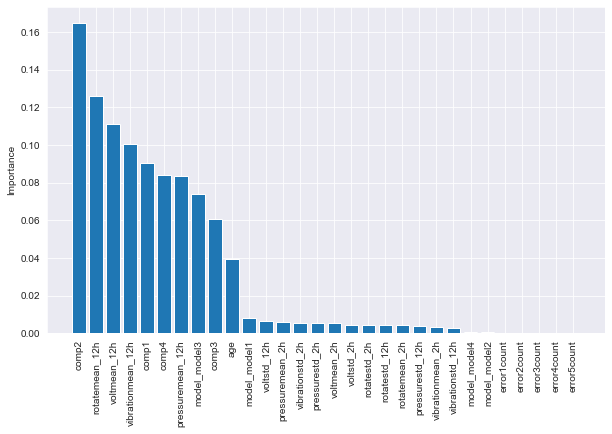

In [9]:
import operator, seaborn as sns, matplotlib.pyplot as plt

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
labels, importances = zip(*sorted(zip(test_X.columns, models[0].feature_importances_),
                                  reverse=True,
                                  key=operator.itemgetter(1)))
plt.xticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.bar(range(len(importances)), importances)
plt.ylabel('Importance')

### 2.2 Model Evaluation

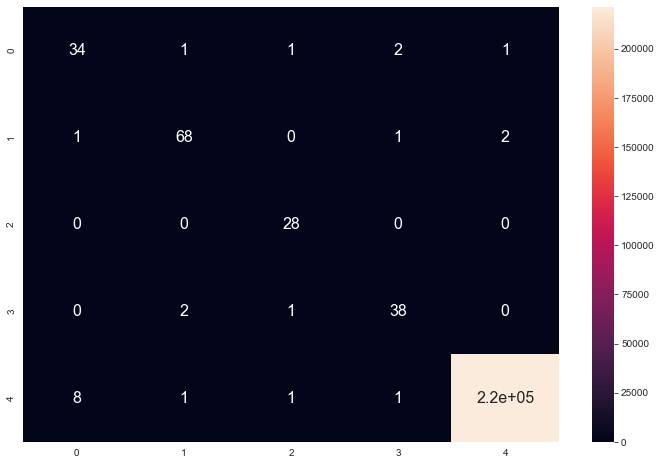

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix(test_result['failure'], test_result['predicted_failure']), annot=True, annot_kws={"size": 16})

In [11]:
print(classification_report(test_result['failure'], test_result['predicted_failure']))

              precision    recall  f1-score   support

       comp1       0.79      0.87      0.83        39
       comp2       0.94      0.94      0.94        72
       comp3       0.90      1.00      0.95        28
       comp4       0.90      0.93      0.92        41
        none       1.00      1.00      1.00    221229

    accuracy                           1.00    221409
   macro avg       0.91      0.95      0.93    221409
weighted avg       1.00      1.00      1.00    221409



## 3. Modelling with Random Forest

### 3.1 Training, Validation and Testing

In [12]:
from sklearn.ensemble import RandomForestClassifier

# train and predict using the model, storing results for later
model = RandomForestClassifier(n_estimators=30,random_state=42,n_jobs=10,max_depth=5,max_features=0.2)
model.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=0.2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=10,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [13]:
models2=[]
test_results2=[]
test_result2 = pd.DataFrame(labeled_features.loc[labeled_features['datetime'] > first_test_date])
test_result2['predicted_failure_rf'] = model.predict(test_X)
test_results2.append(test_result)
models2.append(model)

Text(0, 0.5, 'Importance RF')

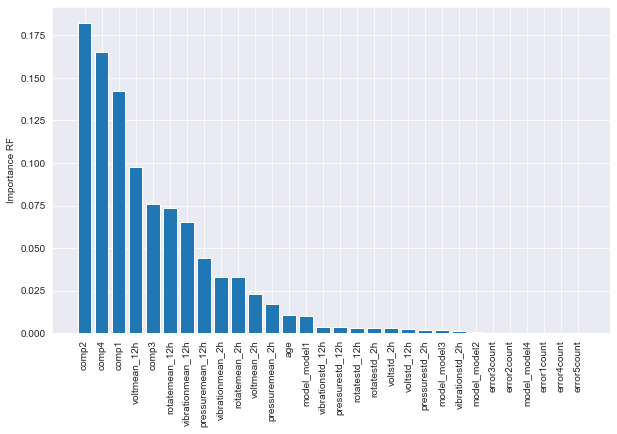

In [17]:
import operator, seaborn as sns, matplotlib.pyplot as plt

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
labels, importances = zip(*sorted(zip(test_X.columns, models2[0].feature_importances_),
                                  reverse=True,
                                  key=operator.itemgetter(1)))
plt.xticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.bar(range(len(importances)), importances)
plt.ylabel('Importance RF')

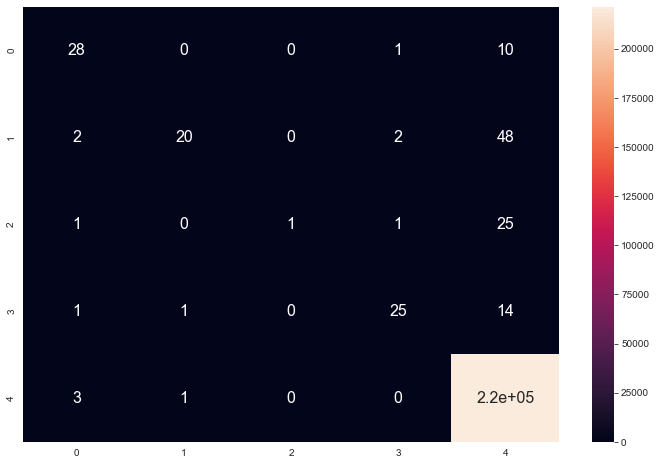

In [18]:
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix(test_result2['failure'], test_result2['predicted_failure_rf']), annot=True, annot_kws={"size": 16})

In [20]:
print(classification_report(test_result2['failure'], test_result2['predicted_failure_rf']))

              precision    recall  f1-score   support

       comp1       0.80      0.72      0.76        39
       comp2       0.91      0.28      0.43        72
       comp3       1.00      0.04      0.07        28
       comp4       0.86      0.61      0.71        41
        none       1.00      1.00      1.00    221229

    accuracy                           1.00    221409
   macro avg       0.91      0.53      0.59    221409
weighted avg       1.00      1.00      1.00    221409

